# Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import portfolio_tool_kit as ptk

# Load the industry returns and the total market index we previously created
ind_return = ptk.get_ind_returns()
tmi_return = ptk.get_total_market_index_returns()

# Constant Proportion Portfolio Insurance (CPPI). 

CPPI strategies are very commonly used and they are definitely worth looking at. The CPPI strategies have been introduced by Black and Jones in 1987. It is a procedure that allows you to generate convex option like payoffs without using option. So it's all about dynamic allocation strategies between risky and safe assets that allow you to get downside protection and upside potential at the same time. 

Now, the principles behind CPPI strategies are actually very simple. What you're going to do is you're going to allocate to a risky asset in multiple M of the difference between your asset value and a given floor. 

What the strategy says is something very simple; at every point in time, you're going to take a look at your cushion, so asset value minus the flow, and you're going to allocate to the risky asset, a multiple of that cushion. 

So what happens clearly is if even when the cash goes down, you're reducing the risky asset allocation. Eventually, if you keep on losing ground as the cushion gets to zero, as your asset value gets to your floor, then your actual allocation is the multiple M times zero because now it go to zero cushion. So now, you're allocating nothing to risky assets 100 percent at this point in time of your assets allocated to your safe component of your portfolio and that allows you to protect your floor. 

Well, let's take a look at the specific example. Let's assume that the multiplier M is equal to 3, let's take a look at a floor which is 80 percent of your current wealth if you will. The question that you want to ask is at this point in time, if you have 100 percent of your wealth, your floor is at 80 percent, how much should you allocate the risky component in this CPPI type mechanism? Well, the answer is very simple. You look at 100USD, which is your initial wealth, you look at the floor, which is 80 percent of that, which is 80USD, so the distance between the two, the cushion is 20. So you're going to allocate the multiple M which is 3 times 20. So in this case, you are going to allocate 60USD the performance seeking portfolio, the risky asset, and 40USD will be invested in the safe asset. 

In [2]:
import pandas as pd
import numpy as np

risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

Now, we need to backtest this strategy by starting at the beginning and at every point in time:

Compute the cushion (asset value minus floor)
Compute the allocation (based on the multiplier)
Compute the new asset value
Although we rarely use for-loops in working with time-series, relying instead of Pandas and Numpy to do the looping internally (and efficiently) this is easier to do with a traditional for-loop.

In [3]:
# set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)

In [4]:
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()

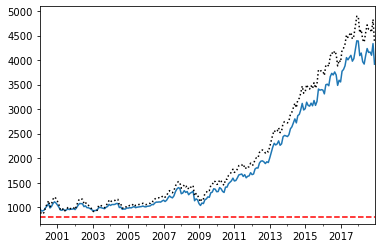

In [5]:
ind = "Beer"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

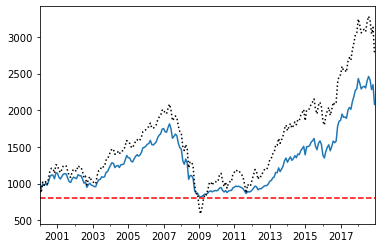

In [6]:
ind = "Fin"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

<AxesSubplot:>

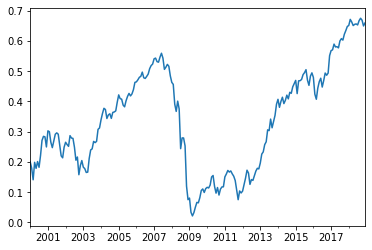

In [7]:
cushion_history["Fin"].plot()

<AxesSubplot:>

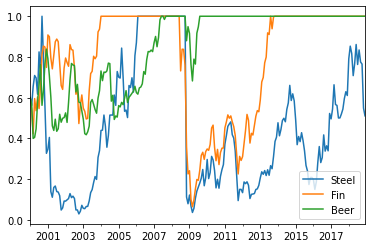

In [8]:
risky_w_history.plot()

Let's put this all into a new function which we can add to our took kit. And while we're at it, let's also write a convenience function to provide summary statistics on a set of returns

<AxesSubplot:>

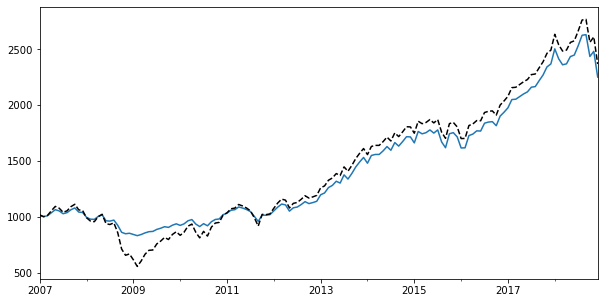

In [9]:
btr = ptk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

<AxesSubplot:>

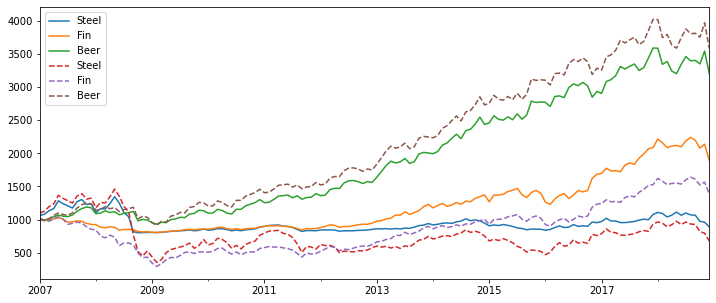

In [10]:
btr = ptk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [31]:
ptk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.098467,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.068951,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.069081,0.608531,-0.217280


In [32]:
ptk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


<AxesSubplot:>

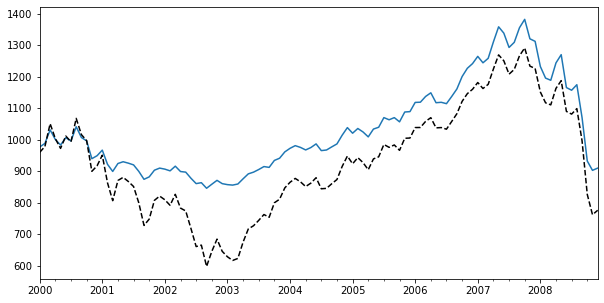

In [33]:
btr = ptk.run_cppi(tmi_return["2000":"2008"])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

# Explicitly Limiting Drawdowns
Insurance strategies usually help with drawdowns, but they can also be adapted to explictly limit the drawdown.

<AxesSubplot:>

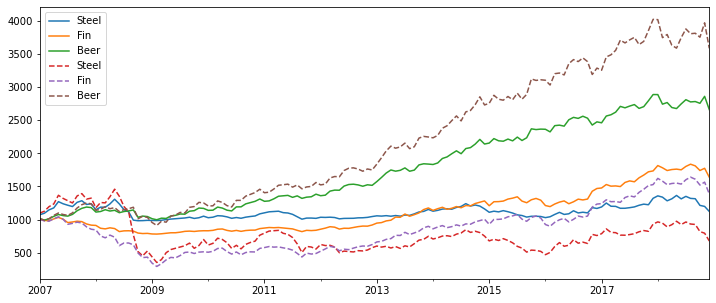

In [34]:
btr = ptk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [36]:
ptk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.262958,-0.248059
Fin,0.041975,0.085028,0.136964,-0.243626
Beer,0.084375,0.086263,0.613413,-0.161186


In [37]:
ptk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.012370,-0.718465
Beer,0.111554,0.127971,0.620132,-0.271368


<AxesSubplot:>

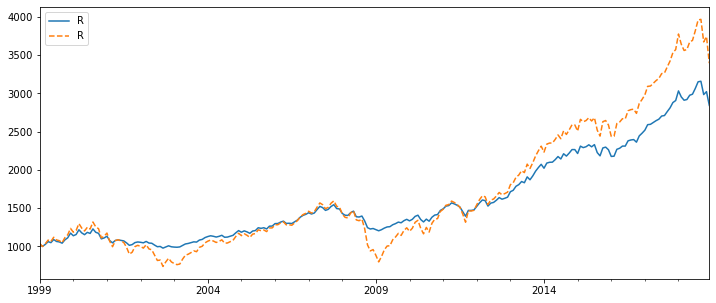

In [38]:
btr = ptk.run_cppi(tmi_return["1999":], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [39]:
ptk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.052391,0.078951,0.275935,-0.220824


In [40]:
ptk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.06137,0.148571,0.205314,-0.499943
